# Principal component analysis (PCA)

Reduccion de dimensionalidad para el analisis de un set de variables numericas. 

### Consideraciones a la hora de conocer los datos con PCA

#### 1. Number of components selection

Es interesante saber previamente cual es el numero de componentes principales que permiten conocer un % de la variabilidad de los datos (normalmente 95 o 99%). Presento una manera grafica y una automatica.

#### 2. Analisis con 2 componentes

> El uso de 2 componentes es recomendado para facilitar la interpretabilidad.
- **Unexplained inertia**: Si la inercia sin explicar es cercana a 0.0 quiere decir que el uso de 2 componentes permite explicar gran parte de la informacion subyacente en la data. En este caso, el resto de resultados del analisis son bastante representativos de la realidad. En caso contrario, habria que aumentar el numero de componentes perdiendose asi interpretabilidad.
- **Two first components distribution**: Este es el grafico mas importante pues permite discernir visualmente si hay patrones subyacentes en los datos. ***En el caso de alto ratio de inercia sin explicar, los resultados no son incompletos. Por otro lado, en el caso de que la distribucion sea random, es decir no muestre ningun patron, los resultados que vienen a partir de aqui no son concluyentes***. Los patrones a identificar son:
    - Clusteres perfectamente definidos. En el caso de contar con labels (array *y*) estos clusters ademas hacerse mas interpretables.
    - Fuertes correlaciones lineales o no lineales en el caso de que ambos componentes dibujen una funcion perfectamente definida.
- **Correlation between components and variables**: Muestra informacion de como se relacionan los componentes principales estimados con las variables analizadas. Mucho cuidado con los resultados obtenidos dado que incluso variables completamente random (dist uniforme) pueden contribuir apreciablemente con un PC. Por tanto, la esta informacion solo es util si los anteriores resultados son buenos (bajo ratio de unexplained inertia y no random distribution de los 2 componentes).
- **Rows contribution distribution**: Esta grafica muestra la contribucion en % de cada uno de los registros de las componentes principales. Este puede ser interesante dado que pueden encontrarse patrones de contribucion, es decir, registros que por una razon determinada, pueden ser omitibles.


#### References

- [Prince library (GitHub homepage)](https://github.com/MaxHalford/prince)
- [PCA — how to choose the number of components? (by Bartosz Mikulski)](https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/)

In [2]:
!pip install prince

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import prince
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [124]:
## Analysis of numerical variables with PCA
def analysis_pca(X:np.array, y:np.array = None, n_components:int = 2):
    """
    Analysis of numerical variables with PCA.
    X -- df or numpy array with numerical features to be analized.
    y -- df series or numpy array with labels to be used to PCs distribution chart.
    n_components -- number of components to be used (default, 2).
    """

    # Standardizing the features
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)

    # initialize PCA
    pca = prince.PCA(
         n_components=n_components,
         n_iter=3,
         rescale_with_mean=True,
         rescale_with_std=True,
         copy=True,
         check_input=True,
         engine='auto',
         random_state=42
    )
    # fit PCA
    pca = pca.fit(X_scaled)
    # display
    print(f"Number of components selected = {n_components}")
    explained_intertia = pca.explained_inertia_
    total_inertia = np.sum(explained_intertia)
    unexplained_intertia = 1. - total_inertia
    print(f'How much each PC explains part of the underlying of the distribution: {explained_intertia} / Total = {total_inertia} / Unexplained inertia = {unexplained_intertia}')
    # transform
    cs = pca.transform(X_scaled)
    
    # plot components 2 first components
    print("Two first components distribution:")
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (10,8))
    ax = pca.plot_row_coordinates(
         X_scaled,
         ax=ax,
         #figsize=(6, 6),
         x_component=0,
         y_component=1,
         labels=None,
         color_labels= None if y is None else y,
         ellipse_outline=False,
         ellipse_fill=True,
         show_points=True
    )
    plt.show()    
    
    # correlation between components and variables
    print('Correlation between components and variables:')
    display(pca.column_correlations(X_scaled))
    
    # rows contribution
    rows_contribution = pca.row_contributions(X_scaled)
    rows_ratio_contribution = rows_contribution / X_scaled.shape[0]
    # plot percent of rows contribution
    print("Rows contribution distribution:")
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (10, 6))
    rows_ratio_contribution.plot(ax = ax)
    ax.set_title("Percent of rows contribution", fontsize = 12)
    ax.set_xlabel("Index")
    ax.set_ylabel("%")
    plt.show()   
    
    # return 
    return None


## Selection of number of PCs para PCA
def pca_number_pcs_selection(X:np.array, variance_threshold:float = .95, is_auto:bool = True):
    """
    Selection of number of PCs para PCA.
    X -- df or numpy array with numerical features to be analized.
    variance_threshold -- percent of variance to be used as cut-off threshold.
    is_auto -- selection of automatic or graphical procedure (default, True).
    """

    # Standardizing the features
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
    # auto procedure
    if is_auto:
        # initialize pca
        pca = PCA(n_components = variance_threshold)
        # fit-transform
        pca.fit(X_scaled)
        reduced = pca.transform(X_scaled)
        # display result
        print(f"Optimal number of PCs for {variance_threshold*100.}% cut-off threshold = {reduced.shape[1]}")
    # graphical procedure
    else:
        # initialize pca
        pca = PCA().fit(X_scaled)

        # display
        import matplotlib.pyplot as plt
        plt.rcParams["figure.figsize"] = (12,6)
        fig, ax = plt.subplots()
        xi = np.arange(1, X_scaled.shape[1]+1, step=1)
        y = np.cumsum(pca.explained_variance_ratio_)
        plt.ylim(0.0,1.1)
        plt.plot(xi, y, marker='o', linestyle='--', color='b')
        plt.xlabel('Number of Components')
        plt.xticks(np.arange(0, X_scaled.shape[1]+1, step=1)) #change from 0-based array index to 1-based human-readable label
        plt.ylabel('Cumulative variance (%)')
        plt.title('The number of components needed to explain variance')
        plt.axhline(y=variance_threshold, color='r', linestyle='-')
        plt.text(0.5, variance_threshold - .05, f'{variance_threshold * 100.}% cut-off threshold', color = 'red', fontsize=16)
        ax.grid(axis='x')
        plt.show()

    # return
    return None

## Iris dataset

In [157]:
# load data
X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
y = pd.Series(y).map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
X.shape, y.shape

((150, 4), (150,))

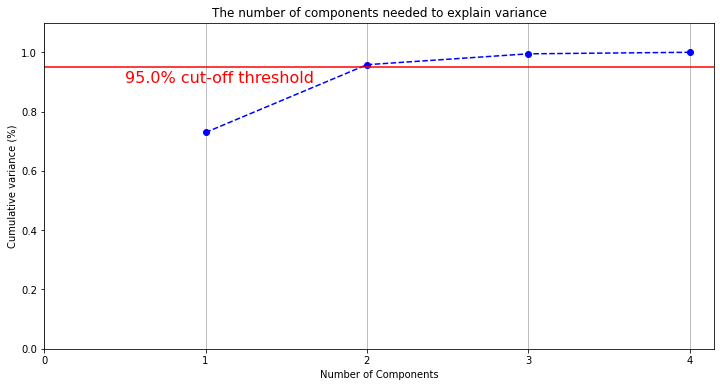

In [158]:
pca_number_pcs_selection(X, variance_threshold = .95, is_auto = False)

Number of components selected = 2
How much each PC explains part of the underlying of the distribution: [0.72962445 0.22850762] / Total = 0.9581320720000163 / Unexplained inertia = 0.041867927999983734
Two first components distribution:


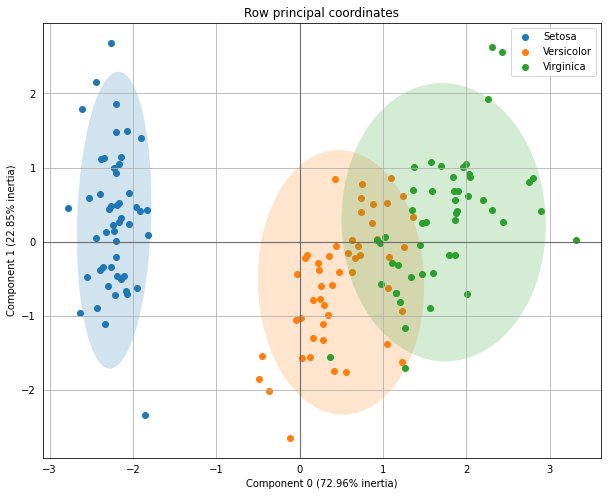

Correlation between components and variables:


,0,1
Petal length,0.991555,0.023415
Petal width,0.964979,0.064000
Sepal length,0.890169,0.360830
Sepal width,-0.460143,0.882716


Rows contribution distribution:


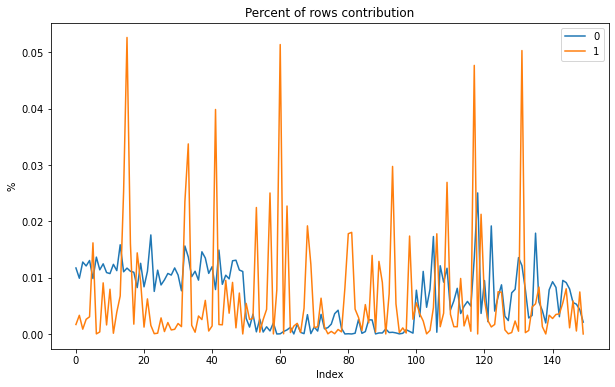

In [159]:
analysis_pca(X, y)

## Iris dataset with an additional random variable (uniform)

In [160]:
# add random variable
import random
X["random"] = [random.uniform(0, 1) for i in range(X.shape[0])]

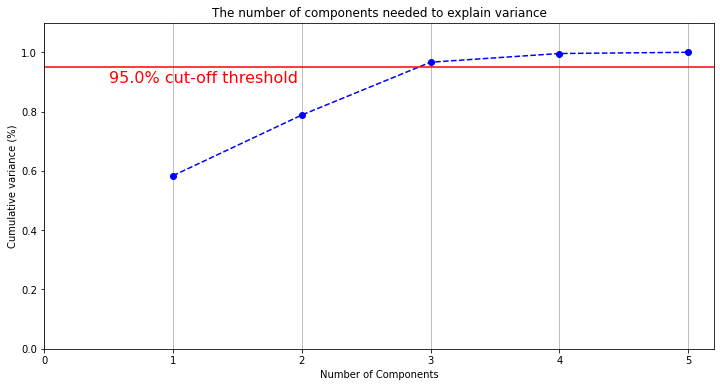

In [161]:
pca_number_pcs_selection(X, variance_threshold = .95, is_auto = False)

Number of components selected = 2
How much each PC explains part of the underlying of the distribution: [0.58379243 0.20458055] / Total = 0.7883729775177309 / Unexplained inertia = 0.21162702248226906
Two first components distribution:


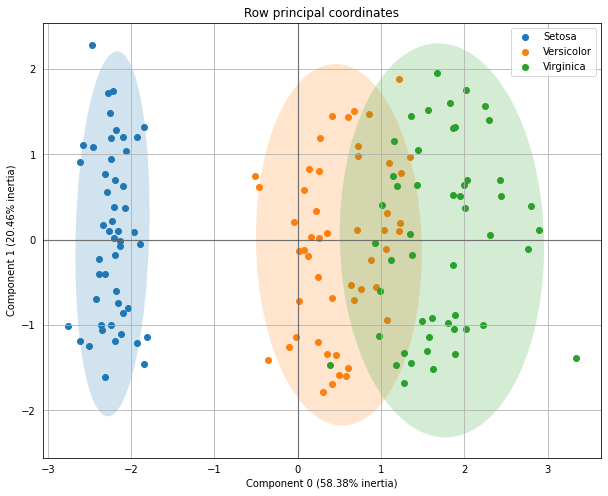

Correlation between components and variables:


,0,1
Petal length,0.991473,0.021322
Petal width,0.964875,0.038779
Sepal length,0.889920,0.163511
Sepal width,-0.460755,0.389958
random,-0.026581,0.917682


Rows contribution distribution:


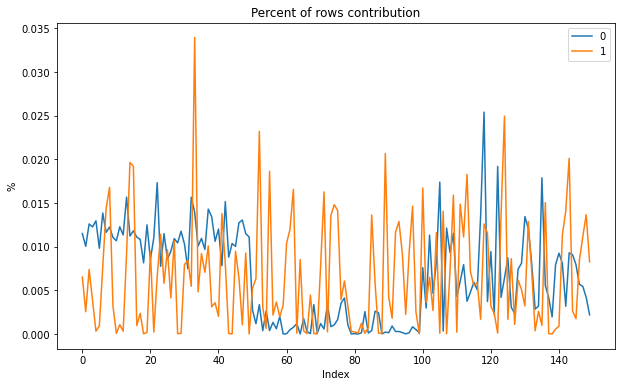

In [162]:
analysis_pca(X, y, n_components = 2)

#### Conclusion

- Al incluir una variable aleatoria uniforme, esta NO ha quedado "marginada" por PCA pues la segunda componente (PC1) correla con esta variable sustancialmente. Unicamente ha introducido ruido que hace que empeore la inercia explicable.

## Iris dataset replacing all features with random variables (uniform)

In [163]:
# load data
X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
y = pd.Series(y).map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
for c in X.columns:
    X[c] = [random.uniform(0, 1) for i in range(X.shape[0])]
X.shape, y.shape

((150, 4), (150,))

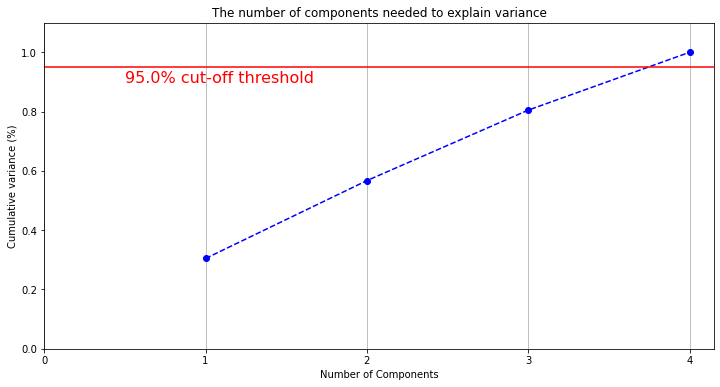

In [164]:
pca_number_pcs_selection(X, variance_threshold = .95, is_auto = False)

Number of components selected = 2
How much each PC explains part of the underlying of the distribution: [0.30471575 0.26256347] / Total = 0.5672792191966525 / Unexplained inertia = 0.4327207808033475
Two first components distribution:


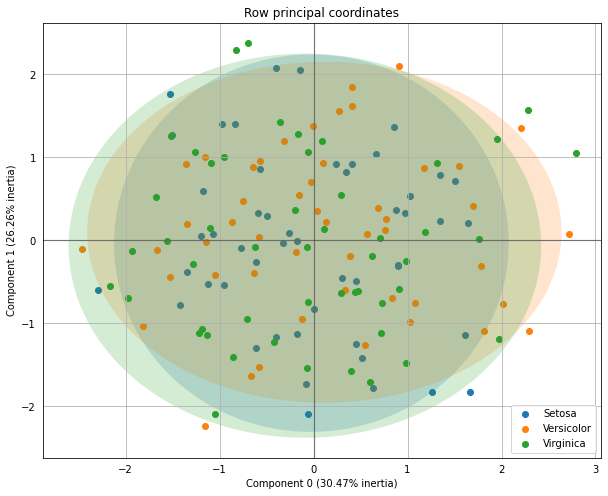

Correlation between components and variables:


,0,1
Petal length,-0.775973,0.081408
Petal width,0.657576,-0.485934
Sepal length,0.347128,0.653989
Sepal width,-0.252633,-0.616273


Rows contribution distribution:


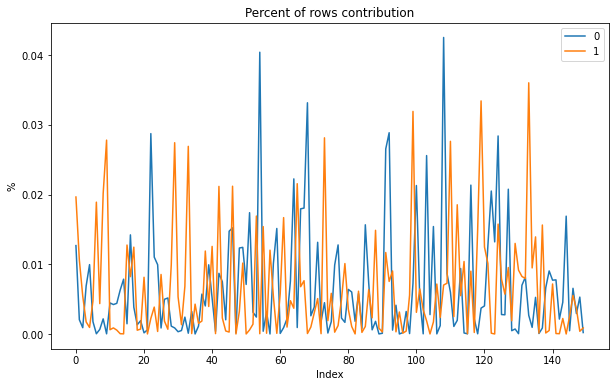

In [165]:
analysis_pca(X, y)

#### Conclusiones

- En el caso de todas las variables random, la inercia explicable de los dos PCs se hunde y en muy similar entre ambas.
- Ademas el scatter plot no muestra ningun patron ni separabilidad. 
- La correlacion con los PCs con las variables si que muestra correlaciones apreciables, sobretodo negativas.
- No sucede obviamente lo mismo con la contribucion de los registros que se vuelve totalmente aleatoria. 